# Statistics Assignment I

Student: Ruslan Mihaylov
Group: DS-01

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

## Implementation

In [2]:
class QuantileTuple:
    """Custom quantile tuple class for representing ranges and quantities of values"""

    def __init__(self, value, g, delta):
        """Initialize a new tuple"""
        self.value = value
        self.g = g
        self.delta = delta

    def __str__(self):
        return f"QuantileTuple(value={self.value}, g={self.g}, delta={self.delta})"

    def __repr__(self):
        return self.__str__()

In [3]:
class GK:
    """Greenwlad and Khanna's algorithm for streaming data"""

    def __init__(self, eps=0.1):
        """
        Set up the small epsilon value for the algorithm
        Along with an empty summary structure
        """

        self.eps = eps    # epsilon value from [0, 1)
        self.summary = [] # structure of tuples <v, g, delta>
        self.n = -1       # length of the analyzed sequence

    def analyze(self, stream):
        """Process a stream of data of construct an approximate quantile summary"""

        # main loop of stream processing
        for n, value in enumerate(stream):

            # deleting entries each 1/(2×eps) insertions
            if n % int(1/(2*self.eps)) == 0:
                self._compress(n)

            # updating the information about quantiles
            self._insert(value)

        # save the length of the sequence
        self.n = len(stream)

    def _compress(self, n):
        """Remove the redundant information about quantiles"""

        i = len(self.summary) - 1
        while i >= 2:
            j = i - 1
            while j >= 1\
                  and sum(t.g for t in self.summary[j:i+1])\
                  + self.summary[i].delta < 2*self.eps*n:
                j -= 1
            j += 1
            if j < i:
                self.summary[i].g = sum(t.g for t in self.summary[j:i+1])
                self.summary = self.summary[:j] + self.summary[i:]
            i = j - 1

    def _insert(self, value):
        """Update the quantile summary with new incoming value"""

        head_or_tail = True
        found_pos = -1
        for i in range(1, len(self.summary)):
            if self.summary[i-1].value <= value < self.summary[i].value:
                head_or_tail = False
                found_pos = i
                break
        if head_or_tail:
            delta = 0
            found_pos = 0 if self.summary and value < self.summary[0].value else len(self.summary)
        else:
            delta = self.summary[found_pos].g + self.summary[found_pos].delta - 1
        self.summary.insert(found_pos, QuantileTuple(value, 1, delta))

    def __call__(self, phi):
        """Run an eps-approximate phi-quantile"""

        # calculate preliminary rank of value in stream
        r = math.floor(phi * self.n)

        # calculate the maximum error in rank
        err = max((t.g+t.delta)/2 for t in self.summary)

        # going through each quantile bin to find the value
        # that represents the needed quantile
        r_min = r_max = 0
        for i in range(len(self.summary)):

            # update the minimum and maximum boundaries for the rank
            r_min += self.summary[i].g
            r_max = r_min + self.summary[i].delta

            if r - err <= r_min and r_max <= r + err:
                return self.summary[i].value

## Validation

In [4]:
# initialize the imitation of streaming data
# distribution is standard normal distribution
stream = np.random.randn(10000)

# set up the engine which runs Greenwlad and Khanna's Algorithm
gk = GK(eps=0.01)

# analyze the streaming data and compute quantile bins
gk.analyze(stream=stream)

# generating testing quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
predicted = [gk(quantile) for quantile in quantiles]
for quantile, pred in zip(quantiles, predicted):
    print(f"Value for {quantile} quantile from stream is {pred}")

# testing if quantiles are in acceptable ranges
# NOTE: values are taken from Z-Score table
ground_truth = [-1.28, -0.67, 0, 0.67, 1.28]
assert np.allclose(predicted, ground_truth, atol=0.1)

Value for 0.1 quantile from stream is -1.2506135828725486
Value for 0.25 quantile from stream is -0.6675717940694954
Value for 0.5 quantile from stream is -0.009498727064859462
Value for 0.75 quantile from stream is 0.6582179902821765
Value for 0.9 quantile from stream is 1.2585171125077939


## Comparison

In [5]:
# increasing n with fixed epsilon to measure space complexity
ns = range(0, 3000, 20)
amount_of_tuples = []
for n in ns:

    # create a processing engine with GK algorithm and process stream
    gk = GK(eps=0.002)
    gk.analyze(np.random.randn(n))

    # save the number of total quantile tuples
    amount_of_tuples.append(len(gk.summary))

/tmp/ipykernel_557557/2806282520.py:2: RuntimeWarning: divide by zero encountered in log
  logs = 125 * (np.log(ns) - 3)


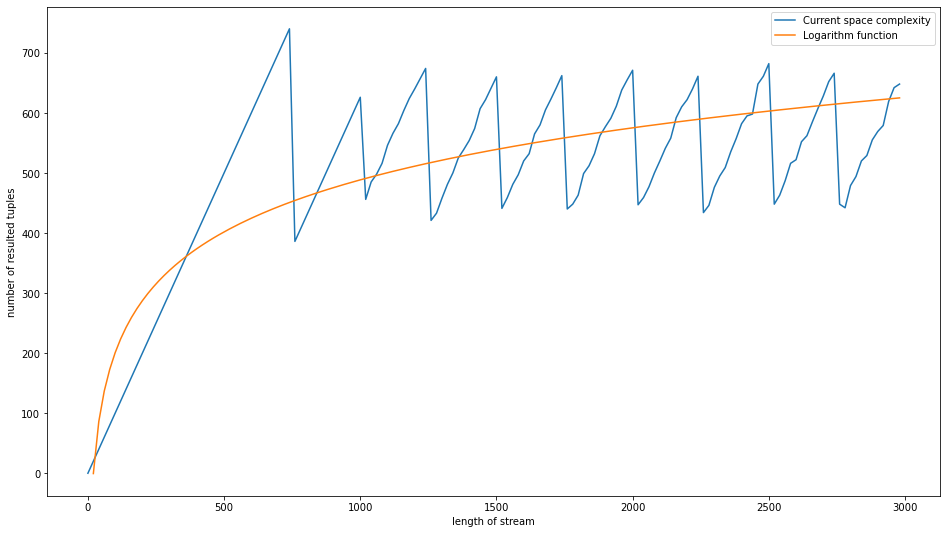

In [6]:
# generate some log function
logs = 125 * (np.log(ns) - 3)

# plot the space complexity on log scale
plt.figure(figsize=(16, 9))
plt.plot(ns, amount_of_tuples)
plt.plot(ns, logs)
plt.ylabel('number of resulted tuples')
plt.xlabel('length of stream')
plt.legend(['Current space complexity', 'Logarithm function'])
plt.show()

## References

* Pseudocode: http://www.mathcs.emory.edu/~cheung/Courses/584/Syllabus/08-Quantile/Greenwald.html#proofprop1
* Main article: http://infolab.stanford.edu/~datar/courses/cs361a/papers/quantiles.pdf